In [2]:
import numpy as np
import numpy.testing as npt
import seaborn as sns
%matplotlib inline

/home/jonas/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


There are 2K tables!
Dice rolls are distributed as a multinomial (aka categorical) distribution.
Each player visits K tables. So the number of timesteps in the model is equal to the number of tables. Use a list of vectors to hold the dice rolls. A set of observations for a single player is a vector containing the sums of their dice rolls at each table. The overall observation set will be a vector of vectors containing the set of observations for each player per vector.

In [3]:
#global state

num_players = 10
K = 1000
num_tables = 2*K
die_sides = 6
timesteps = K

In [4]:
# class Player:
#     def __init__(self):
        

# Generate Distributions

Setting up the emission matrix, seen in https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm

In [5]:
pval_uniform = np.array([1/float(die_sides)] * die_sides)
pval_goodbias = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])
pval_badbias = np.array([0.5, 0.1, 0.1, 0.1, 0.1, 0.1])

emission_matrix = np.vstack([pval_uniform, pval_goodbias, pval_badbias])
print(emission_matrix)
print(emission_matrix.shape)
pval_player_bias = pval_uniform
npt.assert_almost_equal(np.sum(pval_uniform), 1)
npt.assert_almost_equal(np.sum(pval_badbias), 1)
npt.assert_almost_equal(np.sum(pval_goodbias), 1)


transition_matrix = np.array([[0.25, 0.75],
                              [0.75, 0.25]])

[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.1         0.1         0.1         0.1         0.1         0.5       ]
 [ 0.5         0.1         0.1         0.1         0.1         0.1       ]]
(3, 6)


# Roll some dice!

Loop through 1 to K

For each step, use a function to return a distribution.

Roll a dice using the distribution as the tables distribution. Roll a dice using the player distribution. Sum it up, and put it in a vector.

In [6]:
def dice_roll(distribution):
    return np.random.choice([1,2,3,4,5,6], 1, True, distribution)

In [7]:
def visit_tables(emission_matrix, transition_matrix, table_dist_index, tableprime_dist_index, player_dice_dist):
    current_table = 0 #0 for table, 1 for table_prime
    player_rolls = np.zeros(K)
    table_rolls = np.zeros(K)
    dice_sums = np.zeros(K)
    for i in range(K):
        dice_dist = np.random.choice([table_dist_index,tableprime_dist_index], 1, True, transition_matrix[current_table,:])
        table_rolls[i] = dice_roll(emission_matrix[dice_dist[0],:])
        player_rolls[i] = dice_roll(emission_matrix[player_dice_dist,:]) 
        dice_sums[i] = table_rolls[i] + player_rolls[i]
    return dice_sums

# What if all of the dice are uniform?

In [32]:
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,0,0)


(10, 1000)
[ 0.      0.      0.0287  0.0536  0.0851  0.1087  0.1397  0.1706  0.1396
  0.1072  0.0873  0.0536  0.0259]


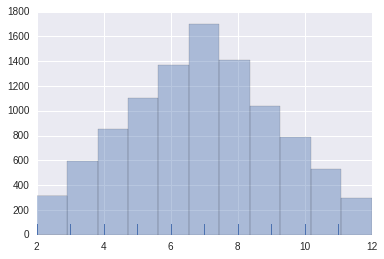

In [9]:
sns.distplot(np.concatenate(overall_observations),bins=11, kde=False, rug=True)

# What if all the dice are uniform except one?

In [10]:
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,1,0)

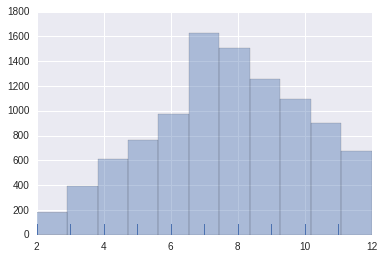

In [11]:
sns.distplot(np.concatenate(overall_observations),bins=11, kde=False, rug=True)

# What if all are bad/biased?
We'll give the table a good bias, and the player a bad bias



In [12]:
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,1,2) #player gets the bad bias

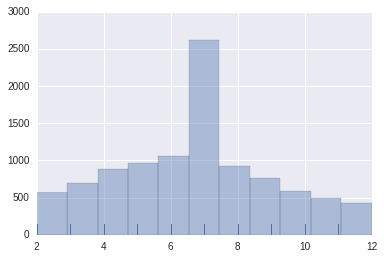

In [13]:
sns.distplot(np.concatenate(overall_observations),bins=11, kde=False, rug=True)

# Construct New Emissions Matrix for Dice Roll Sums

Use the visit tables function using only a single pvalue vector for table and tableprime dice. There will be empty bins for 0 and 1 since those are not possible but still need to be there for the indexing to work properly in the forward/backward algorithm.

In [38]:
## Uniform
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,0,0)

# print(overall_observations.shape)
temp = overall_observations.astype(int)
temp = temp.flatten()
print(np.bincount(temp))
# print(np.bincount(temp)/temp.shape[0])
uniform_emissions = np.bincount(temp)/temp.shape[0]
    
## Good Bias
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 1,1,0)
    
temp = overall_observations.astype(int)
temp = temp.flatten()
goodbias_emissions = np.bincount(temp)/temp.shape[0]    

overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 2,2,0)

temp = overall_observations.astype(int)
temp = temp.flatten()
badbias_emissions = np.bincount(temp)/temp.shape[0]

[   0    0  260  602  843 1157 1382 1662 1341 1149  801  551  252]


In [36]:
new_emissions = np.vstack([uniform_emissions, goodbias_emissions, badbias_emissions])
print(new_emissions)

[[ 0.      0.      0.0287  0.0546  0.0836  0.1096  0.1353  0.1752  0.1288
   0.1124  0.0876  0.0571  0.0271]
 [ 0.      0.      0.0199  0.0331  0.0501  0.0646  0.081   0.1632  0.1541
   0.1289  0.1185  0.1007  0.0859]
 [ 0.      0.      0.0851  0.0971  0.1151  0.1382  0.1484  0.1687  0.0834
   0.062   0.0531  0.0315  0.0174]]


# Forward Algorithm

In [57]:
def fwd(observations, hidden_states, init_state, transition_matrix, emission_matrix):
    L = len(observations)
    fwd = []
    f_prev = []
    for i, x_i in enumerate(observations):
        f_curr = np.zeros(len(hidden_states))
        for state, _ in enumerate(hidden_states):
            if i == 0:
                prev_f_sum = init_state[state]
                print("Prev_f_sum: " + str(prev_f_sum))
            else:
                prev_f_sum = np.sum(f_prev[k]*transition_matrix[k][state] for k, _ in enumerate(hidden_states))
#                 prev_f_sum = sum(f_prev[k]*transition_matrix[k][state] for k in hidden_states)
            f_curr[state] = emission_matrix[state][x_i] * prev_f_sum
            print(f_curr[state])
        fwd.append(f_curr)
        f_prev = f_curr
    p_fwd = sum(f_curr[k] for k, _ in enumerate(hidden_states))

In [58]:
#test out the forward algorithm
states = ('regular', 'primed')
start_probability = [1.0, 0]
fwd(overall_observations[0,:], states, start_probability, transition_matrix, new_emissions[1:,:])

Prev_f_sum: 1.0
0.1632
Prev_f_sum: 0
0.0
0.00263568
0.01691568
0.00108100008
0.000920922912
0.000156825767693
0.000175613458936
1.46817304531e-05
2.81049481476e-06
9.43019167814e-07
1.97613856439e-06
2.21431988396e-07
7.44805390515e-08
5.57204190952e-09
2.12582939095e-08
5.73845793104e-10
9.21829036713e-10
1.66131811936e-11
5.62376205009e-11
1.53357300331e-12
2.57502315809e-12
3.56689201448e-13
1.49614224203e-13
6.66577625783e-15
2.9607776388e-14
3.89595550121e-15
2.09209531019e-15
2.56086178045e-16
1.08517199284e-16
1.46427310082e-17
6.90460890067e-18
1.04743802216e-18
6.74805445558e-19
1.18343189174e-19
7.95869418263e-20
4.47272778353e-21
1.25060900565e-20
2.08905214817e-22
5.51538916736e-22
1.54206442606e-23
2.86021294728e-23
2.04984741175e-24
2.77745670964e-24
5.16515322649e-26
1.89921902552e-25
2.00251705565e-26
5.34558573988e-27
4.51675645396e-28
1.88249207795e-27
1.80687374423e-28
4.29780649127e-29
5.00038834196e-30
2.02131385017e-29
3.26558024139e-31
7.49184307549e-31
3.2240739

/home/jonas/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


NameError: name 'k' is not defined